<a href="https://colab.research.google.com/github/mashyko/object_detection/blob/master/ssd_pytorch_demo.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Demo code for Object Detection with SSD
### Here we demostrate detection on example images using SSD with PyTorch

Adopted from https://github.com/amdegroot/ssd.pytorch  
MIT License Copyright (c) 2017 Max deGroot, Ellis Brown

and updated by mashyko

In [ ]:
!git clone https://github.com/mashyko/ssd.pytorch

fatal: destination path 'ssd.pytorch' already exists and is not an empty directory.


In [ ]:
import os
os.chdir('ssd.pytorch')

In [ ]:
!mkdir weights
%cd weights
!wget https://s3.amazonaws.com/amdegroot-models/vgg16_reducedfc.pth

mkdir: cannot create directory ‘weights’: File exists
/content/ssd.pytorch/weights
--2021-03-02 00:56:29--  https://s3.amazonaws.com/amdegroot-models/vgg16_reducedfc.pth
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.225.187
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.225.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 81938914 (78M) [binary/octet-stream]
Saving to: ‘vgg16_reducedfc.pth.1’

vgg16_reducedfc.pth 100%[===================>]  78.14M  48.1MB/s    in 1.6s    

2021-03-02 00:56:31 (48.1 MB/s) - ‘vgg16_reducedfc.pth.1’ saved [81938914/81938914]



In [ ]:
!wget https://s3.amazonaws.com/amdegroot-models/ssd300_mAP_77.43_v2.pth

--2021-03-02 00:56:31--  https://s3.amazonaws.com/amdegroot-models/ssd300_mAP_77.43_v2.pth
Resolving s3.amazonaws.com (s3.amazonaws.com)... 52.216.225.187
Connecting to s3.amazonaws.com (s3.amazonaws.com)|52.216.225.187|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 105151288 (100M) [application/x-www-form-urlencoded]
Saving to: ‘ssd300_mAP_77.43_v2.pth.1’

ssd300_mAP_77.43_v2 100%[===================>] 100.28M  42.7MB/s    in 2.3s    

2021-03-02 00:56:34 (42.7 MB/s) - ‘ssd300_mAP_77.43_v2.pth.1’ saved [105151288/105151288]



In [ ]:
%cd .. 
!ls data/

/content/ssd.pytorch
coco_labels.txt  eagle.jpg	     img1.jpg  __init__.py  scripts
coco.py		 example.jpg	     img2.jpg  messi.jpg    voc0712.py
config.py	 giraffe.jpg	     img3.jpg  person.jpg
dog.jpg		 herd_of_horses.jpg  img4.jpg  __pycache__


In [ ]:
# need to downgrade pytorch and pillow < 7

!pip install torch==1.0.0 torchvision==0.2.1
!pip install pillow==5.0.0


In [ ]:

import os
import sys

module_path = os.path.abspath(os.path.join('..'))
if module_path not in sys.path:
    sys.path.append(module_path)

import torch
import torch.nn as nn
import torch.backends.cudnn as cudnn
from torch.autograd import Variable
import numpy as np
import cv2
if torch.cuda.is_available():
    torch.set_default_tensor_type('torch.cuda.FloatTensor')

from ssd import build_ssd

## Build SSD300 in Test Phase
1. Build the architecture, specifyingsize of the input image (300),
    and number of object classes to score (21 for VOC dataset)
2. Next we load pretrained weights on the VOC0712 trainval dataset  

In [ ]:
net = build_ssd('test', 300, 21)    # initialize SSD
net.load_weights('weights/ssd300_mAP_77.43_v2.pth')

/content/ssd.pytorch/ssd.py:34: UserWarning: volatile was removed and now has no effect. Use `with torch.no_grad():` instead.
  self.priors = Variable(self.priorbox.forward(), volatile=True)


Loading weights into state dict...
Finished!


## Load Image 
### Here we just load a sample image from the VOC07 dataset 

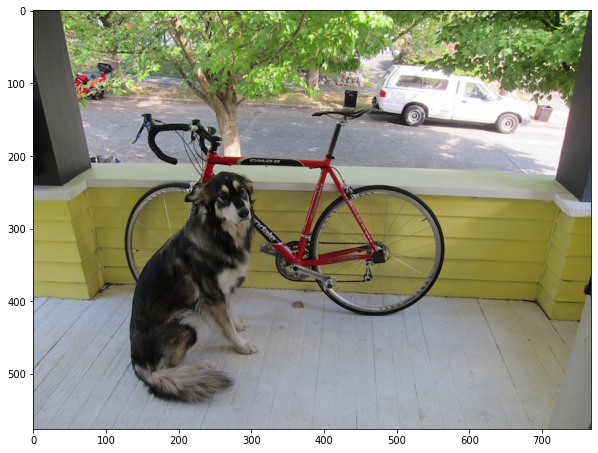

In [ ]:
image = cv2.imread('./data/dog.jpg', cv2.IMREAD_COLOR)  # uncomment if dataset not downloaded
%matplotlib inline
from matplotlib import pyplot as plt
#from data import VOCDetection, VOC_ROOT, VOCAnnotationTransform
# here we specify year (07 or 12) and dataset ('test', 'val', 'train') 
#testset = VOCDetection(VOC_ROOT, [('2007', 'val')], None, VOCAnnotationTransform())
#img_id = 60
#image = testset.pull_image(img_id)
rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
# View the sampled input image before transform
plt.figure(figsize=(10,10))
plt.imshow(rgb_image)
plt.show()

## Pre-process the input.  
#### Using the torchvision package, we can create a Compose of multiple built-in transorm ops to apply 
For SSD, at test time we use a custom BaseTransform callable to
resize our image to 300x300, subtract the dataset's mean rgb values, 
and swap the color channels for input to SSD300.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


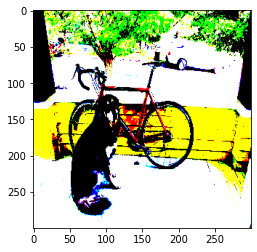

In [ ]:
x = cv2.resize(image, (300, 300)).astype(np.float32)
x -= (104.0, 117.0, 123.0)
x = x.astype(np.float32)
x = x[:, :, ::-1].copy()
plt.imshow(x)
x = torch.from_numpy(x).permute(2, 0, 1)

## SSD Forward Pass
### Now just wrap the image in a Variable so it is recognized by PyTorch autograd

In [ ]:
xx = Variable(x.unsqueeze(0))     # wrap tensor in Variable
if torch.cuda.is_available():
    xx = xx.cuda()
y = net(xx)

## Parse the Detections and View Results
Filter outputs with confidence scores lower than a threshold 
Here we choose 60% 

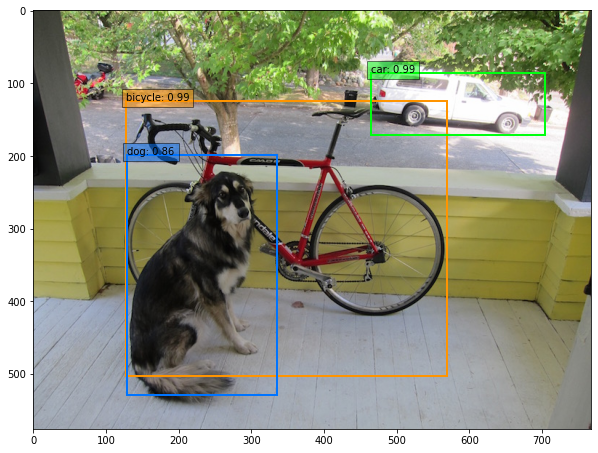

In [ ]:
from data import VOC_CLASSES as labels
top_k=10

plt.figure(figsize=(10,10))
colors = plt.cm.hsv(np.linspace(0, 1, 21)).tolist()
plt.imshow(rgb_image)  # plot the image for matplotlib
currentAxis = plt.gca()

detections = y.data
# scale each detection back up to the image
scale = torch.Tensor(rgb_image.shape[1::-1]).repeat(2)
for i in range(detections.size(1)):
    j = 0
    while detections[0,i,j,0] >= 0.6:
        score = detections[0,i,j,0]
        label_name = labels[i-1]
        display_txt = '%s: %.2f'%(label_name, score)
        pt = (detections[0,i,j,1:]*scale).cpu().numpy()
        coords = (pt[0], pt[1]), pt[2]-pt[0]+1, pt[3]-pt[1]+1
        color = colors[i]
        currentAxis.add_patch(plt.Rectangle(*coords, fill=False, edgecolor=color, linewidth=2))
        currentAxis.text(pt[0], pt[1], display_txt, bbox={'facecolor':color, 'alpha':0.5})
        j+=1